# Causal Data Science Week 3 Tutorial


### Backdoor Criterion

The backdoor criterion allows us to identify the variables on which we need to condition to calculate our causal estimates. We identify these variables by looking at 'backdoor' paths from the treatment variable.

Given a CBN $(G = (\mathbf{V}, \mathbf{E}), p)$ and a distinct pair of variables $X_i, Y_j \in \mathbf{V}$, a set $\mathbf{Z} \subseteq \mathbf{V} \setminus \{i,j\}$ satisfies the
**backdoor criterion** for estimating the causal effect of $X_i$ on $X_j$ if:
- $\mathbf{Z}$ does not contain any descendant of $i$, $Desc(i) \cap \mathbf{Z} = \emptyset$, **and**
- $\mathbf{Z}$ blocks all backdoor paths from $i$ to $j$ (all paths that start with an arrow into $i \gets ... j$)

The example below is taken from: https://medium.data4sci.com/causal-inference-part-xi-backdoor-criterion-e29627a1da0e. To make the examples more clear, instead of using indices we will use capital letters to denote both the variables and their corresponding vertices in the causal graph.

In [19]:
import pandas as pd
import networkx as nx
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

data = pd.read_csv("lalonde_data.csv")

data.info()
var_names = data.columns.to_list()
var_names

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722 entries, 0 to 721
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   treat      722 non-null    float64
 1   age        722 non-null    float64
 2   education  722 non-null    float64
 3   black      722 non-null    float64
 4   hispanic   722 non-null    float64
 5   married    722 non-null    float64
 6   nodegree   722 non-null    float64
 7   re75       722 non-null    float64
 8   re78       722 non-null    float64
dtypes: float64(9)
memory usage: 50.9 KB


['treat',
 'age',
 'education',
 'black',
 'hispanic',
 'married',
 'nodegree',
 're75',
 're78']

Let's create a network and manually identify adjustment sets based on the backdoor criterion. We want to find effect of $treat$ on $re78$.

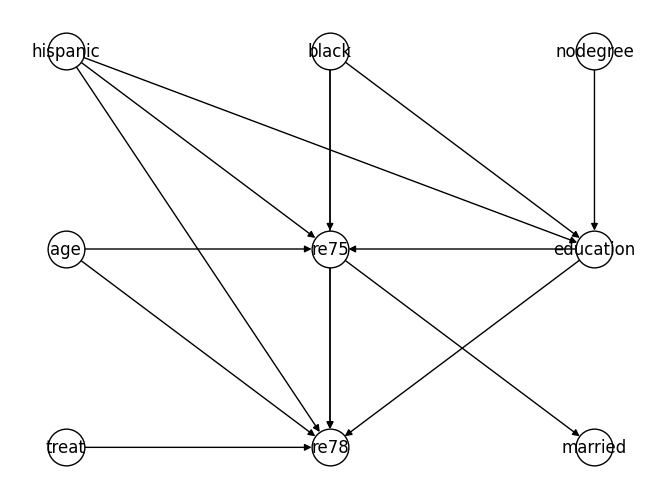

In [20]:
# The graph that we started with

graph_v0 = nx.DiGraph()

graph_v0.add_nodes_from(var_names)

graph_v0.add_edges_from([(var_names[0], var_names[8]), (var_names[1], var_names[7]), (var_names[1], var_names[8]), 
                  (var_names[2], var_names[7]), (var_names[2], var_names[8]), (var_names[6], var_names[2]), 
                  (var_names[7], var_names[5]), (var_names[7], var_names[8]), (var_names[3], var_names[2]), (var_names[4], var_names[2]),
                  (var_names[3], var_names[7]), (var_names[4], var_names[7]), (var_names[3], var_names[8]), (var_names[4], var_names[8])])
                    # (var_names[8], var_names[5])])

coordinates = [(-1,-1), (-1, 0), (1, 0), (0, 1), (-1, 1), (1, -1), (1, 1), (0, 0), (0, -1)]
pos= {key: val for key, val in zip(var_names, coordinates)}

nx.draw(graph_v0, pos= pos, with_labels=True, node_size=700, node_color='w', edgecolors ='black')
nx.write_gml(graph_v0, "backdoor_criterion_graph.gml")

In [21]:
# # The final graph

# G = nx.DiGraph()
# covariates = var_names[1:8]

# edges = []

# # Connect each covariate to 'treat' and 're78'
# for covariate in covariates:
#     edges.append((covariate, 'treat'))
#     edges.append((covariate, 're78'))

# edges.append(('treat', 're78'))

# # Update the graph
# # G.clear()
# G.add_edges_from(edges)

# # Define positions
# positions = {}
# for i, covariate in enumerate(covariates):
#     positions[covariate] = (0, -i)
# positions['treat'] = (1, -len(covariates) / 2)
# positions['re78'] = (2, -len(covariates) / 2)

# # Add positions as node attributes
# for node, pos in positions.items():
#     G.nodes[node]['pos'] = f"{pos[0]},{pos[1]}"

# nx.draw(G, pos=positions, with_labels=True, node_size=700, node_color='w', edgecolors='black', font_size=10)
# nx.write_gml(G, "backdoor_criterion_graph.gml")

We can start by identifying the descendants of $X$, as these must <u>not</u> be in our adjustment set according to the backdoor criterion. The descendants of $X$ are: $X$, $W$, and $Y$.

In [22]:
# this function finds the descendants of node 'X' in graph G
# note that in this function does not return 'X' as a descendant of 'X' - this is not the definition we use, so we add 'X'
nx.descendants(graph_v0,'treat') | {'treat'}

{'re78', 'treat'}

We now consider every backdoor path from $X$ to $Y$, and find the variables for which we can/must adjust. We start off by importing the 'backdoor' class from DoWhy.

In [23]:
# importing the backdoor class from DoWhy
from dowhy.causal_identifier import backdoor

Then, we create an undirected copy of our graph and call it $H$ so we can find all possible undirected paths between $X$ and $Y$.

In [24]:
# creating a copy of our graph G that is undirected
H = graph_v0.to_undirected()

In [25]:
# the all_simple_paths function finds all possible undirected paths between 'X' and 'Y' in graph H
all_possible_paths = list(nx.all_simple_paths(H, 'treat', 're78'))
for path in all_possible_paths:
    print(path)

['treat', 're78']


Finally, we can use the `is_backdoor` method of a `Backdoor` instance to check which of these paths are backdoor paths.

In [26]:
# we can create a Backdoor object with G, 'X', and 'Y'
# note that we are back to using the directed graph, G, as we only needed the undirected to find the paths
bd = backdoor.Backdoor(graph_v0, 'education', 're78')

In [27]:
# we apply the is_backdoor function to each path to check if a path is a backdoor path
backdoor_paths = [path for path in all_possible_paths if bd.is_backdoor(path)]
for path in backdoor_paths:
    print(path)

Now we can find possible adjustment sets for each of these paths.

In [28]:
# we create a pandas dataframe to track the path and its colliders and non-colliders
import pandas as pd
import numpy as np
adjustment_variables = pd.DataFrame(columns=['path', 'colliders(and descendants)', 'non_colliders'])

In [30]:
# colors = ['black', 'r', 'r', 'r', 'black', 'r', 'black', 'black']
# nx.draw(G, pos= positions, with_labels=True, node_size=600, node_color='w', edgecolors = 'black')

DoWhy can find sets satisfying the backdoor criterion automatically. We simply provide it with the graph (in .gml format). We also need to provide it with data, but since we are only worried about the backdoor criterion for now, we can give it meaningless data (remember: the estimands are graph-specific, and don't rely on the data).

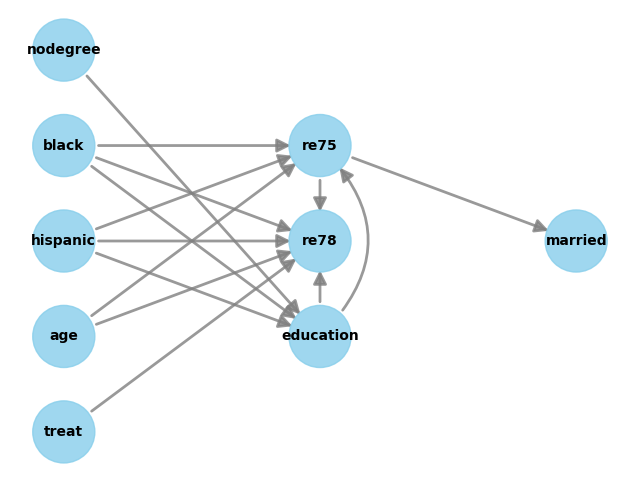

In [31]:
import dowhy
from dowhy import CausalModel
from IPython.display import Image, display

# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

gml_graph = gml_to_string('backdoor_criterion_graph.gml')
# With GML string

model=CausalModel(
    data = data,
    treatment='education',
    outcome='re78',
    graph=gml_graph
)

# model=CausalModel(
#     data = data,
#     treatment='hispanic',
#     outcome='re78',
#     graph=gml_graph,
    
# )


model.view_model() # need to check how I can adjust the node positions in this visualization :(((

In [32]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                              
────────────(E[re78|hispanic,black])
d[education]                        
Estimand assumption 1, Unconfoundedness: If U→{education} and U→re78 then P(re78|education,hispanic,black,U) = P(re78|education,hispanic,black)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢     d            ⎛     d                  ⎞  ⎥
E⎢───────────(re₇₈)⋅⎜───────────([education])⎟  ⎥
 ⎣d[nodegree]       ⎝d[nodegree]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→re78 then ¬(U →→{nodegree})
Estimand assumption 2, Exclusion: If we remove {nodegree}→{education}, then ¬({nodegree}→re78)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Under Estimand 1, we can see the adjustment set identified by DoWhy. This set will be one of those we manually found, but can differ from run to run.

DoWhy's code for finding the backdoor criterion sets is available at: https://github.com/microsoft/dowhy/blob/master/dowhy/causal_identifiers/backdoor.py. You can look into this a bit if you want to understand better how DoWhy finds the adjustment sets. For example, you can access all the minimum-sized and maximum-sized adjustment sets as follows:

In [33]:
identifier = model.identifier
identifier.identify_backdoor(model._graph._graph, model._treatment, model._outcome, list(model._graph.get_all_nodes(include_unobserved=False)))

[{'backdoor_set': ('treat', 'age', 'hispanic', 'black', 'nodegree')},
 {'backdoor_set': ('hispanic', 'black')}]

In [34]:
# Estimating treatment effect with vaious methods

estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print("backdoor.linear_regression ATE :", estimate.value)

# estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_matching")
# print("backdoor.propensity_score_matching ATE:", estimate.value)

backdoor.linear_regression ATE : 276.7037000625055
